In [1]:
#Importing the usual libraries.
import numpy as np
import tensorly as tl
import seaborn as sns
import matplotlib.pyplot as plt
import multilinearalgebra

from tqdm import tqdm
from scipy.io import loadmat

#Setting style options.
sns.set()
np.set_printoptions(3)

The following packages are used in this notebook:

- `numpy 1.18.1`
- `tensorly 0.4.3`
- `seaborn 0.10.0`

# Problem 1 

For the third-order tensor $\mathbf{\mathcal{X}} \in \mathbb{C}^{I \times J \times K}$ provided in the file “cpd_tensor.mat”, implement the plain-vanilla Alternating Least Squares (ALS) algorithm that estimates the factor matrices $\mathbf{A} \in \mathbb{C}^{I \times R}$ , $\mathbf{B} \in \mathbb{C}^{J \times R}$ and $\mathbf{C} \in \mathbb{C}^{K \times R}$ by solving the following problem:

\begin{equation}
    (\hat{\mathbf{A}}, \hat{\mathbf{B}}, \hat{\mathbf{C}}) = \underset{\mathbf{A}, \mathbf{B}, \mathbf{C}}{min} || \mathbf{\mathcal{X}} - \sum^{R}_{r = 1} \mathbf{a}_{r} \circ \mathbf{b}_{r} \circ \mathbf{c}_{r} ||^{2}_{F}
\end{equation}

where $A = [a_{1} , . . . , a_{R}]$, $B = [b_{1} , . . . , b_{R}]$ and $C = [c_{1} , . . . , c_{R}]$. Considering a successful run,
compare the estimated matrices $\hat{\mathbf{A}}$, $\hat{\mathbf{B}}$ and $\hat{\mathbf{C}}$ with the original ones. Explain the results.

Hint: An error measure at the i-th iteration can be calculated from the following formula:

\begin{equation}
    e_{(i)} = || [\mathbf{\mathcal{X}}]_{(1)} - \hat{\mathbf{A}}_{(i)}(\hat{\mathbf{C}}_{(i)} \diamond \hat{\mathbf{B}}_{(i)})^{T}||_{F}
\end{equation}

The convergence at the i-th iteration can be declared when $e_{(i−1)} − e_{(i)} < \delta$, where $\delta$ is a
prescribed threshold value (e.g. $\delta = 10^{-6}$).

<font color='red'>Solution:</font>

In [2]:
def cpd_decomposition(tensor,rank,inter_max,delta):
    
    def unfold(tensor,n):
    
        if n == 0:
            tensor = np.moveaxis(tensor,n,0)
            tensor_unfolding = tensor.reshape(tensor.shape[0],-1,order = 'F')
    
        else:
            tensor = np.moveaxis(tensor,n,0)
            tensor_unfolding = tensor.reshape(tensor.shape[0],-1)
    
        return tensor_unfolding

    shapes = tensor.shape
    
    #B = np.random.rand(shapes[2],rank)
    #C = np.random.rand(shapes[0],rank)
    
    [_,U,_] = multilinearalgebra.HOSVD(tensor)
    B = U[1][:,0:rank]
    C = U[2][:,0:rank]
    
    tensor_1mode = unfold(tensor,1)
    tensor_2mode = unfold(tensor,2)
    tensor_3mode = unfold(tensor,0)
    
    error = np.zeros([inter_max])
    error[0] = 0
    for inter in range(1,inter_max):
        
        A = tensor_1mode@np.linalg.pinv(((multilinearalgebra.kr(C,B)).T))
        B = tensor_2mode@np.linalg.pinv(((multilinearalgebra.kr(C,A)).T))
        C = tensor_3mode@np.linalg.pinv(((multilinearalgebra.kr(B,A)).T))
        
        error[inter] = np.linalg.norm(tensor_1mode - A@(multilinearalgebra.kr(C,B).T),'fro')**2/(np.linalg.norm(tensor_1mode, 'fro')**2)
        
        if abs(error[inter] - error[inter-1]) <= delta:
            break
            
        else:
            continue
            
    return A,B,C,error[1:inter],inter - 1

In [3]:
CPD_TENSOR = loadmat('cpd_tensor.mat')
A = CPD_TENSOR['A']
B = CPD_TENSOR['B']
C = CPD_TENSOR['C']

tenX = CPD_TENSOR['tenX'] 
tenX = tenX.transpose(2,0,1)
print(tenX.shape)

(5, 8, 4)


In [4]:
[A_approx, B_approx, C_approx, error, inter] = cpd_decomposition(tenX, 3, 1000, 1e-10)

In [5]:
print('NMSE for A Stimation:')
print(multilinearalgebra.normalized_mean_square_error(A,A_approx))

print('NMSE for B Stimation:')
print(multilinearalgebra.normalized_mean_square_error(B,B_approx))

print('NMSE for C Stimation:')
print(multilinearalgebra.normalized_mean_square_error(C,C_approx))

tenX_approx = A_approx@(tl.tenalg.khatri_rao([C_approx,B_approx]).T)
tenX_approx = multilinearalgebra.fold(tenX_approx,tenX.shape,1)
print('NMSE for tenX Stimation:')
print(multilinearalgebra.normalized_mean_square_error(tenX,tenX_approx))

print('Number of Iterations:')
print(inter)

NMSE for A Stimation:
14.066706880934943
NMSE for B Stimation:
0.98414490191783
NMSE for C Stimation:
1.5409974438293388
NMSE for tenX Stimation:
7.344218194444908e-11
Number of Iterations:
28


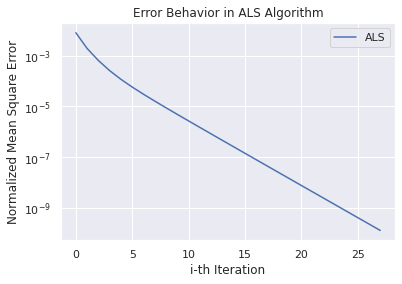

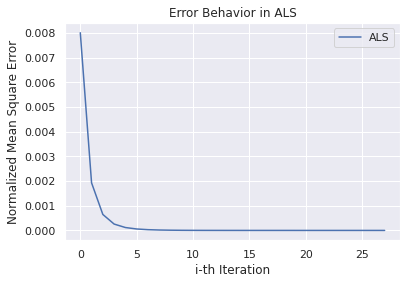

In [6]:
plt.figure()
plt.semilogy(error,'b', label = 'ALS')
plt.title('Error Behavior in ALS Algorithm')
plt.xlabel('i-th Iteration')
plt.ylabel('Normalized Mean Square Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(error,'b', label = 'ALS')
plt.title('Error Behavior in ALS')
plt.xlabel('i-th Iteration')
plt.ylabel('Normalized Mean Square Error')
plt.legend()
plt.show()

# Problem 2

Assuming 1000 Monte Carlo experiments, generate a tensor $\mathbf{\mathcal{X}_{0}} = CPD(\mathbf{A},\mathbf{B},\mathbf{C})$ where $\mathbf{A} \in \mathbb{C}^{I \times R}$ , $\mathbf{B} \in \mathbb{C}^{J \times R}$ and $\mathbf{C} \in \mathbb{C}^{K \times R}$ have unit norm columns with elements randomly drawn from a Normal distribution, with R = 3. Let $\mathbf{\mathcal{X}} = \mathbf{\mathcal{X}_{0}} + \alpha \mathbf{\mathcal{V}}$ be a noisy version of $\mathbf{\mathcal{X}}$ where $\mathbf{\mathcal{V}}$ is the additive noise term, whose elements are drawn from a normal distribution. The parameter $\alpha$ controls the power (variance) of the noise term, and is defined as a function of the signal to noise ratio (SNR), in dB, as follows:

\begin{equation}
    SNR_{dB} = 10 \log_{10} \frac{||\mathbf{\mathcal{X}_{0}}||^{2}_{F}}{||\alpha \mathbf{\mathcal{V}}||^{2}_{F}}
\end{equation}

Assuming the SNR range $[0, 5, 10, 15, 20, 25, 30]$ dB, find the estimates $\hat{\mathbf{A}}$, $\hat{\mathbf{B}}$ and $\hat{\mathbf{C}}$ obtained with the ALS algorithm for the configurations $(I,J,K) = (10,4,2)$.

Let us define the normalized mean square error (NMSE) measure as follows:

\begin{equation}
    NMSE(\mathbf{X_{0}}) = \frac{1}{1000} \sum^{1000}_{i = 1} \frac{||\hat{\mathbf{\mathcal{Q}_{0}(i)}} - \mathbf{\mathcal{Q}_{0}(i)}||^{2}_{F}}{||\mathbf{\mathcal{Q}_{0}(i)}||^{2}_{F}}
\end{equation}

where $\mathbf{\mathcal{Q}_{0}(i)}$ and $\hat{\mathbf{\mathcal{Q}_{0}(i)}}$ represent the original data matrix and the reconstructed one at the ith Monte Carlo experiment, respectively. For each SNR value and configuration, plot the NMSE(A), NMSE(B) and NMSE(C) as a function of the SNR. Discuss the obtained results.

<font color='red'>Solution:</font>

In [7]:
def cpd_decomposition_montecarlo(X_0,list_of_matrices,rank,inter_max,delta,snr_dB):
    
    #Obtaining the size of the array SNR_db
    Size = len(snr_dB)
    #Creating an array to alocate the values of NMSE per run.
    NMSE_A = np.zeros(Size)
    NMSE_B = np.zeros(Size)
    NMSE_C = np.zeros(Size)
    NMSE_X = np.zeros(Size)
    INTER = np.zeros(Size)
    
    #This loop controls the number of runs in the Monte Carlo simulation.
    runs = 1000
    for k in tqdm(range(runs)):
        
        #Creating the noise array.
        V = np.random.normal(0,1,X_0.shape) + 1j*np.random.normal(0,1,X_0.shape)
        
        #This loop will run through the SNR_db vector.
        for i in range(0,Size):
            
            #Converting the SNR that it is in dB to the linear scale.
            snr_Linear = 10**(snr_dB[i]/10)
            
            #The process to obtain the value of alpha that will adjust the noise to the desirable value of SNR.
            alphaV = ((np.linalg.norm(X_0))**2)/snr_Linear
            alpha = np.sqrt(alphaV/((np.linalg.norm(V))**2))
            
            #Adding the desirable noise to the original signal X_0.
            X = X_0 + alpha*V
            [A_approx, B_approx, C_approx, error, inter] = cpd_decomposition(X,rank,inter_max,delta)
            
            #Obtaining the NMSE for the k-th run of the MCS at the SNR_dB[i].
            NMSE_A[i] = NMSE_A[i] + multilinearalgebra.normalized_mean_square_error(list_of_matrices[0],A_approx)
            NMSE_B[i] = NMSE_B[i] + multilinearalgebra.normalized_mean_square_error(list_of_matrices[1],B_approx)
            NMSE_C[i] = NMSE_C[i] + multilinearalgebra.normalized_mean_square_error(list_of_matrices[2],C_approx)
            NMSE_X[i] = NMSE_X[i] + error[-1]
            INTER[i] = INTER[i] + inter
            
    #Obtaining the mean of all the runs.
    NMSE_A = NMSE_A/runs
    NMSE_B = NMSE_B/runs
    NMSE_C = NMSE_C/runs
    NMSE_X = NMSE_X/runs
    
    INTER = INTER/runs
    
    return NMSE_A,NMSE_B,NMSE_C,NMSE_X,INTER

In [8]:
ALS_CPD_TENSOR = loadmat('cpd_tensor.mat')
A = ALS_CPD_TENSOR['A']
B = ALS_CPD_TENSOR['B']
C = ALS_CPD_TENSOR['C']

tenX = ALS_CPD_TENSOR['tenX'] 
tenX = tenX.transpose(2,0,1)
print(tenX.shape)

(5, 8, 4)


In [9]:
snr_dB = [0,5,10,15,20,25,30,35,40,45,50]
[NMSE_A,NMSE_B,NMSE_C,NMSE_X,INTER] = cpd_decomposition_montecarlo(tenX,np.array([A,B,C,]),3,1000,10**-12,snr_dB)

100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]


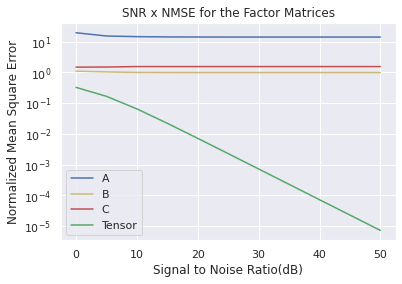

In [10]:
plt.figure()
plt.semilogy(snr_dB,NMSE_A,'b', label = 'A')
plt.semilogy(snr_dB,NMSE_B,'y', label = 'B')
plt.semilogy(snr_dB,NMSE_C,'r', label = 'C')
plt.semilogy(snr_dB,NMSE_X,'g', label = 'Tensor')
plt.title('SNR x NMSE for the Factor Matrices')
plt.xlabel('Signal to Noise Ratio(dB)')
plt.ylabel('Normalized Mean Square Error')
plt.legend()
plt.show()

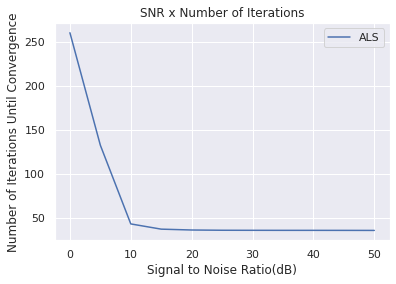

In [11]:
plt.figure()
plt.plot(snr_dB,INTER,'b', label = 'ALS')
plt.title('SNR x Number of Iterations')
plt.xlabel('Signal to Noise Ratio(dB)')
plt.ylabel('Number of Iterations Until Convergence')
plt.legend()
plt.show()

## About this notebook

**Author**: Kenneth B. dos A. Benício

**Uptaded on**: 2020-04-30